# DATA620: Final Project Proposal - Federal Reserve Sentiment

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

Your proposal should describe at a high level what you’re seeking to accomplish, and your motivation for performing this analysis.  A guiding question or hypothesis to test is one good way to start.  If you are going to work in a small group (encouraged!), you should also list your partners’ names. 
You should briefly describe your data sources, plan for doing the work, and up front concerns.  If you are working in a group, please describe the roles and responsibilities of each group member.
We’ll treat this proposal as a planning document, not a blue print containing “firm, fixed requirements.”
Your final project proposal is due on Monday 12/9. 

## Import Modules

In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from textblob import Word

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import spacy
import spacy.cli
from spacy.lang.en import English

from textatistic import Textatistic
from wordcloud import WordCloud

import networkx as nx
import warnings
from scipy.stats import ttest_ind
plt.rcParams.update({'axes.facecolor':'orange'})


## Functions

In [2]:
# Function that returns average word length
def avg_word_length(x):
    # Split the string into words
    words = x.split()
    # Compute length of each word and store in a separate list
    word_lengths = [len(word) for word in words]
    # Compute average word length
    avg_word_length = sum(word_lengths)/len(words)
    # Return average word length
    return(avg_word_length)


def filter_propn(s):
    
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    
    
    # Load model and create Doc object
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(s)

    # Generate lemmatized tokens
    lemmas = [token.lemma_ for token in doc]

    # Remove stopwords and non-alphabetic tokens
    a_lemmas = [lemma for lemma in lemmas 
                if lemma.isalpha() and lemma not in stopwords]

    a_lemmas = ' '.join(a_lemmas)
    doc_lemmas = nlp(a_lemmas)

    # Generate list of tokens and pos tags
    pos = [(token.text, token.pos_) for token in doc_lemmas]
    
    l = list(zip(*pos))[0]
    l = sorted(set(l))
    
    return ' '.join(l)


def get_city_name(n):
    nlp = spacy.load('en_core_web_sm')

    doc = nlp(n)
    places = [str(ent) for ent in doc.ents if ent.label_ in ['GPE', 'LOC']]

    return ' '.join(places)
   

<br><br>
## Introduction

For most of its 108 year history the deliberations of the federal reserve were clocked in secrecy and conducted behind closed doors. Successive Federal Reserve Chair believed that the organizations ability to effectively conduct monetary policy relied on it ability to operate behind closed doors. Alen Greenspan expressed this sentiment in his October 11, 2001 speech to the Federal Reserve Bank of St. Louis, Economic Policy Conference.

<blockquote><i>
Human nature being what it is, the vast majority of us are disinclined to offer half-thought-through, but potentially useful, policy notions only to have them embarrassingly dissected in front of a national television audience. When undertaken in such a medium, deliberations tend toward the less provocative and less useful. I do not say that such a system cannot function, but I do say that in my three decades in and out of government, I have never seen it function well.
</i></blockquote>

During his tenure as the Federal Reserve Chair from August 1987 to January 2006 Alan Greenspan was notoriously opaque about federal reserve policy. 


<br>More Recently the Federal Reserve has embarked on an effort to be more transparent. Perhaps non coincidentally this effort corresponds to the recent events when the Fed has been pressed to uses extraordinary measure to prevent economic meltdowns and deep recessions. The next three Fed Chairs have voiced support for institutional transparency. 


<br>Ben Bernanke (Fed Chair February 2006 - January 2014) - in a speech to <b> The Institute for Monetary and Economic Studies International Conference, Bank of Japan, Tokyo, Japan </b>

<blockquote><i>
Transparency regarding monetary policy in particular not only helps make central banks more accountable, it also increases the effectiveness of policy. Clarity about the aims of future policy and about how the central bank likely would react under various economic circumstances reduces uncertainty and--by helping households and firms anticipate central bank actions--amplifies the effect of monetary policy on longer-term interest rates. The greater clarity and reduced uncertainty, in turn, increase the ability of policymakers to influence economic growth and inflation.
</i></blockquote>


<br>Janet Yellen (Fed Chair February 2014-February 2018) in a 2017 speech for the <b> Paul H. Douglas Award for Ethics in Government </b> details how transparency and communication are essential to preventing corruption.




<br>Jerome H. Powell (Fed Chair Since February 2018) in 2018 at Sveriges Riksbank anniversary conference

<blockquote><i>
In a democratic system, any degree of independence brings with it the obligation to provide appropriate transparency. In turn, transparency provides an essential basis for accountability and democratic legitimacy by enabling effective legislative oversight and keeping the public informed.4
</i></blockquote>


<br>The transparency goals of the Fed are clear but have the efforts of the 3 most recent Fed Chairs been successful. Can we demonstrate the level of transparency from the Fed Reserve? How consistent is the messaging leading up to a decision by Federal Reserve Open Market Committee (FOMC)? In this analysis we will analyze the speeches from the Federal Reserve Chair to determine if the communication leading up to decision by the FOMC provides visibility into decision. In other words does the Federal Reserve Chair telegraph the actions of the FOMC during their public speeches leading up to FOMC Meeting and the change in the Federal Funds Rate? 



<br><br>

### Federal Reserve System

The Federal Reserve Act, created The Federal Reserve System on December 23, 1913. The Federal Reserve's system has 3 primary components:
- 12 Federal Reserve Banks 
- Federal Reserve Board of Governors
- Federal Open Market Committee

This is a unique structure among central banks in that it includes both public and private characteristics. The division of responsibility across 12 Federal Reserve Banks creates a decentralized system of monetary policy control. 

The Fed has many key functions however its activities can be categorized by the Dual Mandate setup by the Congress in the Federal Reserve Act. 
- maximum employment
- stable prices
The dual mandate is the long-run goal for monetary policy, and the Congress also established the Federal Reserve as an independent agency to help ensure that this monetary policy goal can be achieved.

To support these objectives the federal reserve employs monetary policy through 3 primary mechanisms
- open market operations
- the discount rate
- reserve requirements

To understand the Fed's monitory policy this analysis will focus on the formal decision making process that follow an FOMC Meeting. 

<br><br>

## Hypothesis

In the time leading up FOMC Meeting the Fed Chair and the Governors of the 12 Federal Reserve Banks will develop an economic outlook that will inform their vote at the FOMC Meeting. One way to measure transparency is to evaluate how well this economic outlook is communicated to the general public through speeches. Fortunately for this analysis the Fed tracks all speeches by it board of governors and posts them to www.federalreserve.gov with transcripts.

For this analysis we can categorize the periods between FOMC meeting by their outcome. In each meeting the interest rate target will either be increased, decreased or remain the same. For each type of FOMC meeting outcome we would like to understand if the communication by the representatives of the Fed is consistent and predictable. 

- H0 - Communications by Federal Reserve Chair do not telegraph the outcome of the upcoming FOMC Meeting. There is no decipherable difference in speeches by Fed Chair during periods of increase, decreasing or stable interest rates. 

- H1 - Federal Reserve Chair will telegraph the outcome of the upcoming FOMC Meeting through their communications. The speeches by Fed Chair will differ predictably during periods of increase, decreasing or stable interest rates.  


<br><br>
## Data Source
There are several sources of prepossessed data from the Fed Reserve speeches and FOMC Meeting outcomes, however it might be necessary to augment these data set to get the latest information. For the purposes of this analysis we will create two unique data sets. 

1. Aggregate FOMC Decisions - the outcome of each FOMC meeting is captured in a broader write-up however the decision can be distilled into meeting date, meeting location, decision to increase, decrease or leave interested unchanged, and a magnitude of the change, and the new target range for interest rates
2. Aggregate Speeches by FOMC Members - Each member of the FOMC maintains a detailed calendar of speeches that includes, location, audience, speech title, speech text.

The ability to forecast result of an FOMC meeting can generate significant financial gains as a result there is a large body of work analyzing the topic, using a variety of methods. 

<br>
<b>Reference Sources</b>


<br>

Meeting calendars, statements, and minutes (2017-2022)
* https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm
* https://fraser.stlouisfed.org/title/statements-speeches-alan-greenspan-452?browse=1980s#8366
* https://www.thebalance.com/fomc-meetings-schedule-and-statement-summaries-3305975

<br>
Federal Funds Effective Rate (FEDFUNDS)

* https://fred.stlouisfed.org/series/FEDFUNDS
* https://www.thebalance.com/fed-funds-rate-history-highs-lows-3306135#toc-fed-chair-alan-greenspan-august-1987-january-2006
* https://www.bankrate.com/banking/federal-reserve/history-of-federal-funds-rate/

<br>
List of Governors and their terms

* https://en.wikipedia.org/wiki/Chair_of_the_Federal_Reserve
* https://en.wikipedia.org/wiki/Federal_Reserve_Board_of_Governors

<br>
History of FOMC decisions

* https://www.federalreserve.gov/monetarypolicy/fomc.htm
* https://en.wikipedia.org/wiki/History_of_Federal_Open_Market_Committee_actions

<br>
Analysis

* https://www.kaggle.com/datasets/natanm/federal-reserve-governors-speeches-1996-2020?resource=download
* https://towardsdatascience.com/fedspeak-how-to-build-a-nlp-pipeline-to-predict-central-bank-policy-changes-a2f157ca0434




<br>

### FOMC Fed Rate Decision (events)

The Federal Open Market Committee meets a minimum of 8 times a year in regularly scheduled sessions. During these sessions the representatives from the Federal Reserve member banks will discuss their economic outlook. At the conclusion of each meeting the member of FOMC will reach consensus on a monetary policy decision. The data set below captures the result of the FOMC meetings since May 1987.

In [3]:
decision_df = pd.read_csv('data/Manual_Event.csv')
decision_df['event_date']  = pd.to_datetime(decision_df['event_date'])
decision_df['date_diff'] = decision_df['event_date'].diff()
decision_df['start_date'] = decision_df['event_date'] - decision_df['date_diff']
decision_df['end_date'] = decision_df['event_date']
decision_df['event_id'] = 'E' + decision_df.index.astype(str)
decision_df = decision_df.drop(['id'], axis=1)
decision_df.head()

,event_date,fed_rate,action,rate_change,fed_chair,notes,date_diff,start_date,end_date,event_id
0,1987-05-19,0.0650,increase,0.0062,Paul Volcker,Continued raising rates to fight inflation,NaT,NaT,1987-05-19,E0
1,1987-07-07,0.0650,no change,0.0000,Alan Greenspan,- no change -,49 days,1987-05-19,1987-07-07,E1
2,1987-08-18,0.0650,no change,0.0000,Alan Greenspan,- no change -,42 days,1987-07-07,1987-08-18,E2
3,1987-09-22,0.0725,increase,0.0075,Alan Greenspan,No notable event,35 days,1987-08-18,1987-09-22,E3
4,1987-11-04,0.0681,decrease,-0.0044,Alan Greenspan,Lowered after Black Monday stock market crash,43 days,1987-09-22,1987-11-04,E4


In [4]:
decision_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   event_date   302 non-null    datetime64[ns] 
 1   fed_rate     302 non-null    float64        
 2   action       302 non-null    object         
 3   rate_change  302 non-null    float64        
 4   fed_chair    302 non-null    object         
 5   notes        302 non-null    object         
 6   date_diff    301 non-null    timedelta64[ns]
 7   start_date   301 non-null    datetime64[ns] 
 8   end_date     302 non-null    datetime64[ns] 
 9   event_id     302 non-null    object         
dtypes: datetime64[ns](3), float64(2), object(4), timedelta64[ns](1)
memory usage: 23.7+ KB


<br><br>

The graph below captures the target Federal Funds rate overtime. It also highlight the respective Fed Chair during that period.

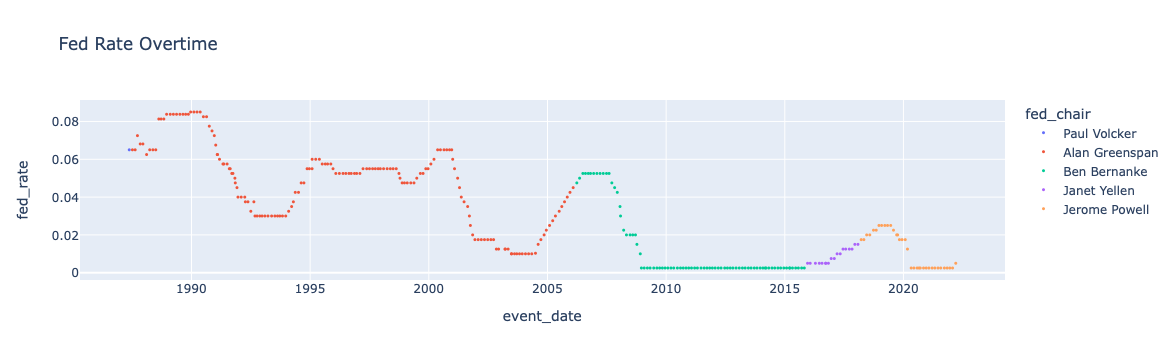

In [57]:
import statsmodels.api as sm

fig = px.scatter(data_frame=decision_df, 
                x='event_date', y='fed_rate', 
                color="fed_chair", 
                title='Fed Rate Overtime',
            )

fig.update_traces(marker_size=3)

fig.show()

<br><br>

The graph below captures the relative change in Federal Funds rate overtime. It also highlights the respective Fed Chair during the period. 

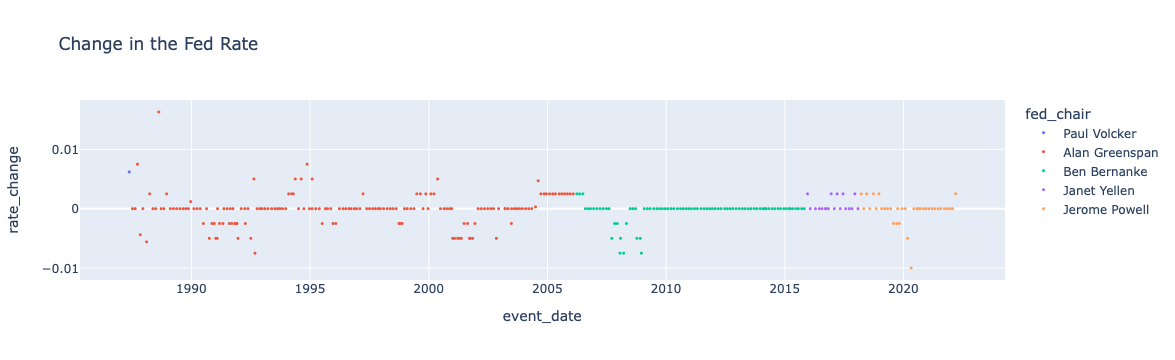

In [46]:
fig = px.scatter(data_frame=decision_df, 
                x='event_date', y='rate_change', 
                color="fed_chair", 
                title='Change in the Fed Rate',   
            )

fig.update_traces(marker_size=3)

fig.show()

<br><br>

### Federal Reserve Chairman Communications (speeches)

The speeches by the Federal Reserve Chair are captured in the following dataframe. The data set is fitered down to speeches by Fed Chairs including Alan Greenspan, Ben S. Bernanke, Janet L. Yellen, Jerome H. Powell. The data set is also cleaned up for stop words and custom stop words.

In [7]:
# load speeches
speech_df = pd.read_csv('data/fed_speeches_1996_2020.csv', parse_dates=['speech_date'] , encoding='utf_8')
speech_df = speech_df[speech_df['text_len'] > 50]
speech_df['year'] = speech_df['year'].astype(int)

# filter by Fed Chair
list_of_values = ['Chairman Alan Greenspan','Chairman Ben S. Bernanke','Chair Janet L. Yellen','Chairman Jerome H. Powell']
speech_df = speech_df[speech_df['speaker'].isin(list_of_values)]
speech_df['speaker'].value_counts(sort=True)


Chairman Alan Greenspan      183
Chairman Ben S. Bernanke     169
Chair Janet L. Yellen         44
Chairman Jerome H. Powell     32
Name: speaker, dtype: int64

In [8]:
stop_words = set(stopwords.words('english')) 
custom_stopwords = set(('chairman','chair','alan','greenspan','ben','bernanke','janet', 'yellen','jerome','powell',',',' ','.', ';', '?', '-', '!', '(', ')','--','"',"'", ':', '¡¦', '¡','', '9', '/'))

speech_df['speech_id'] = 'S' + speech_df.index.astype(str)
speech_df['text'] = speech_df['text'].str.lower()
speech_df['text'] = speech_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_stopwords)]))
speech_df['filter_text'] = speech_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
speech_df['filter_text'] = speech_df['filter_text'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))
speech_df['filter_text_len'] = speech_df['filter_text'].apply(lambda x: len(x.split()))
speech_df['avg_word_length_filter'] = speech_df['filter_text'].apply(avg_word_length)
speech_df.head()

,link,title,speaker,event,year,text,speech_date,text_len,location,speech_id,filter_text,filter_text_len,avg_word_length_filter
1,https://www.federalreserve.gov/boarddocs/speec...,Social security,Chairman Alan Greenspan,At the Abraham Lincoln Award Ceremony of the U...,1996,i am privileged to accept the union league of ...,1996-12-06,2596,Pennsylvania,S1,privileged accept union league philadelphia's ...,1551,6.969697
2,https://www.federalreserve.gov/boarddocs/speec...,The challenge of central banking in a democrat...,Chairman Alan Greenspan,At the Annual Dinner and Francis Boyer Lecture...,1996,the challenge of central banking in a democrat...,1996-12-05,4344,D.C.,S2,challenge central banking democratic society g...,2379,7.200504
6,https://www.federalreserve.gov/boarddocs/speec...,Banking in the global marketplace,Chairman Alan Greenspan,At the Federation of Bankers Associations of J...,1996,banking in the global marketplace it is again ...,1996-11-18,5963,Japan,S6,banking global marketplace pleasure tokyo invi...,3369,7.342832
9,https://www.federalreserve.gov/boarddocs/speec...,Technological advances and productivity,Chairman Alan Greenspan,At the 80th Anniversary Awards Dinner of The C...,1996,remarks by technological advances and producti...,1996-10-16,1690,New York,S9,remark technological advance productivity 80th...,942,7.060510
12,https://www.federalreserve.gov/boarddocs/speec...,U.S. Treasury securities market: Lessons from ...,Chairman Alan Greenspan,At the Annual Public Service Awards Dinner of ...,1996,remarks by u.s. treasury securities market: le...,1996-10-07,1191,New York,S12,remark u.s. treasury security market: lesson a...,670,6.865672


In [9]:
speech_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 1 to 1443
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   link                    428 non-null    object        
 1   title                   428 non-null    object        
 2   speaker                 428 non-null    object        
 3   event                   428 non-null    object        
 4   year                    428 non-null    int64         
 5   text                    428 non-null    object        
 6   speech_date             428 non-null    datetime64[ns]
 7   text_len                428 non-null    int64         
 8   location                428 non-null    object        
 9   speech_id               428 non-null    object        
 10  filter_text             428 non-null    object        
 11  filter_text_len         428 non-null    int64         
 12  avg_word_length_filter  428 non-null    float64  


<br><br>

### merge events and location

By merging the event and the speech data frames we can associate each speech with a period and FOMC action.

In [10]:
df_merge = decision_df.merge(speech_df, how='cross')
df_merge = df_merge.query('speech_date > start_date and speech_date <= end_date')
df_merge.head(5)

,event_date,fed_rate,action,rate_change,fed_chair,notes,date_diff,start_date,end_date,event_id,...,event,year,text,speech_date,text_len,location,speech_id,filter_text,filter_text_len,avg_word_length_filter
35959,1996-07-03,0.0525,no change,0.0,Alan Greenspan,- no change -,43 days,1996-05-21,1996-07-03,E84,...,At the International Conference of Banking Sup...,1996,remarks by bank supervision in a world economy...,1996-06-13,3164,Sweden,S18,remark bank supervision world economy internat...,1837,7.357104
36814,1996-09-24,0.0525,no change,0.0,Alan Greenspan,- no change -,35 days,1996-08-20,1996-09-24,E86,...,At the U.S. Treasury Conference on Electronic ...,1996,remarks by regulation of electronic payment sy...,1996-09-19,1948,D.C.,S15,remark regulation electronic payment system u....,1132,7.118375
37239,1996-11-13,0.0525,no change,0.0,Alan Greenspan,- no change -,50 days,1996-09-24,1996-11-13,E87,...,At the 80th Anniversary Awards Dinner of The C...,1996,remarks by technological advances and producti...,1996-10-16,1690,New York,S9,remark technological advance productivity 80th...,942,7.060510
37240,1996-11-13,0.0525,no change,0.0,Alan Greenspan,- no change -,50 days,1996-09-24,1996-11-13,E87,...,At the Annual Public Service Awards Dinner of ...,1996,remarks by u.s. treasury securities market: le...,1996-10-07,1191,New York,S12,remark u.s. treasury security market: lesson a...,670,6.865672
37241,1996-11-13,0.0525,no change,0.0,Alan Greenspan,- no change -,50 days,1996-09-24,1996-11-13,E87,...,At the Annual Convention of the American Banke...,1996,"remarks by bank supervision, regulation, and r...",1996-10-05,2346,Hawaii,S13,"remark bank supervision, regulation, risk annu...",1354,7.335303


In [11]:
#df_merge['event_key'] = df_merge['event'].apply(filter_propn)

In [12]:
#df_merge[['event','event_key']]

In [13]:
#df_merge['location_key'] = df_merge['location'].apply(get_city_name)

In [14]:
#df_merge[['location','location_key']]

In [15]:
#df_merge['location_key'].value_counts(sort=True)

In [16]:
#len(df_merge['location_key'].value_counts(sort=True))

## Analysis

Using the merged dataframe we can review speeches by Fed Chairs for consistency given the outcome of the FOMC meeting. We can analyze all speeches that leading up to a decision to increase, decrease or hold rates steady. Using the outcome of the FOMC meeting as label we can analyze the sentiment from each speech to determine transparency and consistency. 

<br>
<b>Approach</b>

1. The outcomes of the FOMC meeting will be used to label speeches by Board Members, Each speech takes place during a period where the FOMC board will decide to increase, decrease or leave interest rates unchanged. The speech can then be parsed for and scored using sentiment analysis

2. The records of the speech will be used to create a network graph where the nodes will be speaker, audience, location?. The edges will be sentiment and the meta data from the relevant FOMC meeting.

3. Grouping the communications by FOMC Meeting outcome, Speaker, Audience, Timeframe we can analyze the clarity of message from the Federal Reserve.

<br>

<br>

### FOMC Decision Events

The following graph anayzes the FOMC actions by Meeting outcome. The rates of activity are not consistent. No action or holding interest rates stable is by far the most prominent outcome in the dataset. 

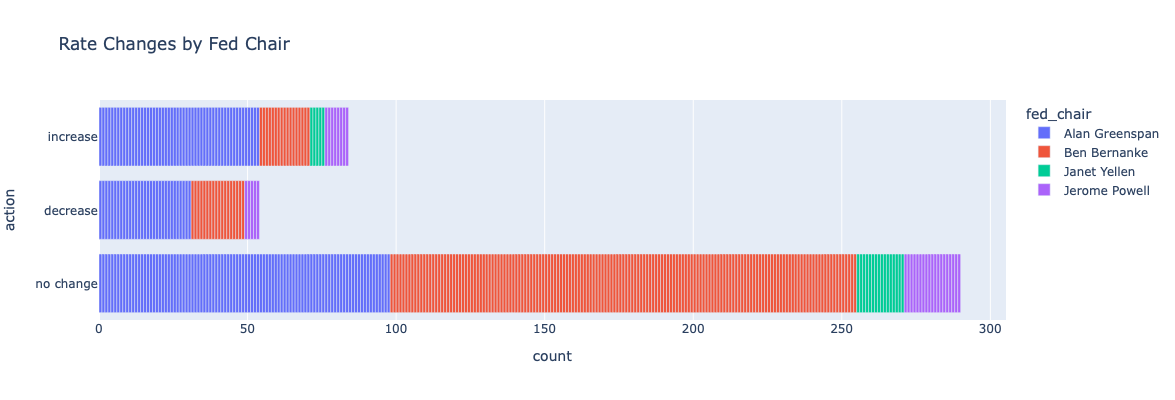

In [17]:
fig = px.bar(df_merge, y="action", color='fed_chair', orientation='h',
             hover_data=["action", "rate_change"],
             height=400,
             title='Rate Changes by Fed Chair')
fig.show()

<br>

### Speech Length

The length of speeches distributed as a histogram when we consider all words.

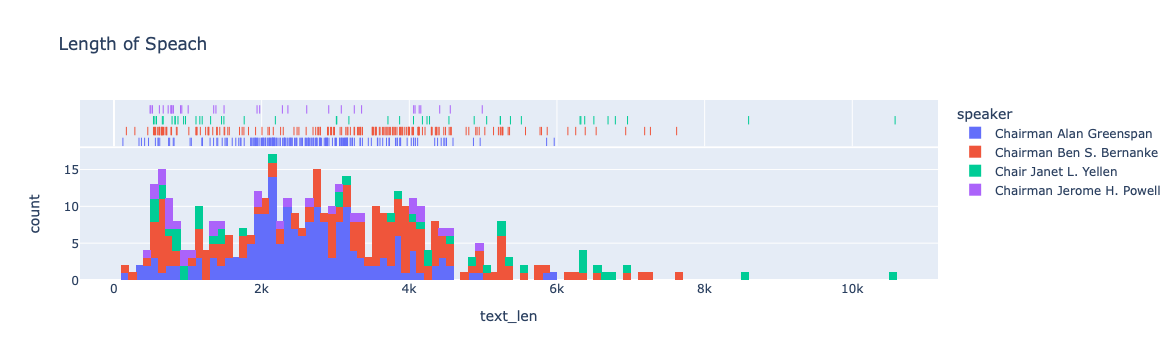

In [49]:
fig = px.histogram(df_merge, x="text_len", marginal="rug", color='speaker', nbins=150, hover_data=['speaker','title']
                  ,title="Length of Speach")
fig.show()

<br>

The length of speeches distributed as a histogram once stopwords have been filtered. 

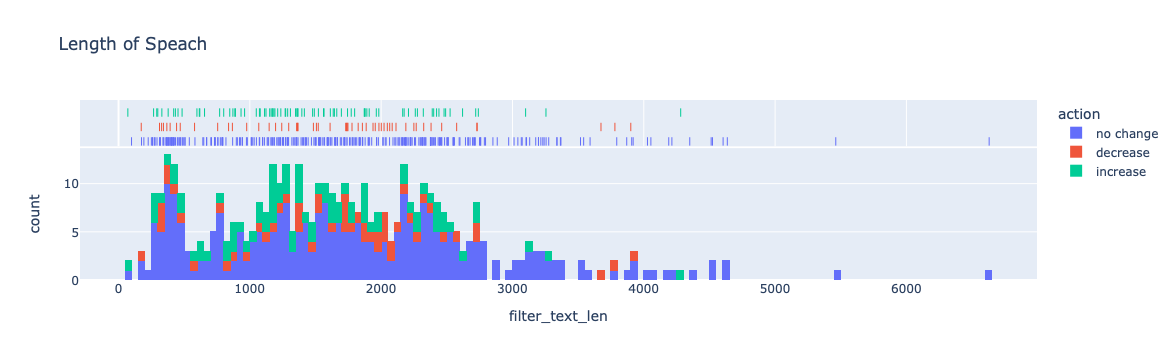

In [50]:
fig = px.histogram(df_merge, x="filter_text_len", color='action' ,marginal="rug",nbins=150, hover_data=['speaker','title']
                  ,title="Length of Speach")
fig.show()

<br>

### Common Words (WordCloud)

The wordcloud highlights the most popular words in the speeches from Fed Chairs. Supervision, Banks, Regulation, Market are common words.

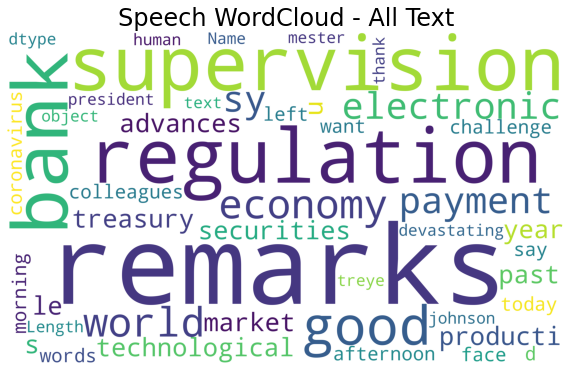

In [20]:
text = str(df_merge['text'])
title = 'Speech WordCloud - All Text'

w = text.split()

words = ' '.join(w)

wordcloud = WordCloud(
                  background_color='white',
                  width=5000,
                  height=3000
                 ).generate(words)
plt.figure(1,figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title(title, fontsize=24)
plt.show()

<br>

The wordcloud highlights the most popular words in the speeches from Fed Chairs once the stopwords are removed.

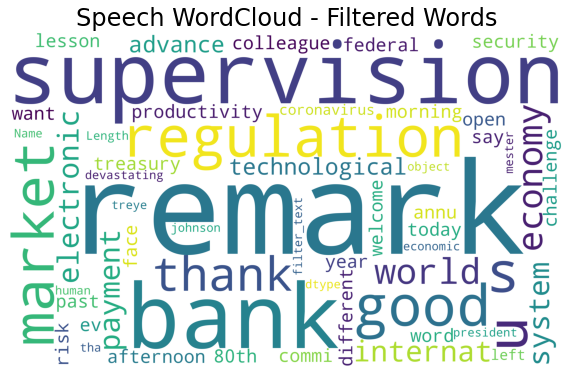

In [21]:
text = str(df_merge['filter_text'])
title = 'Speech WordCloud - Filtered Words'

w = text.split()

words = ' '.join(w)

wordcloud = WordCloud(
                  background_color='white',
                  width=5000,
                  height=3000
                 ).generate(words)
plt.figure(1,figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.title(title, fontsize=24)
plt.show()

<br>

### sentiment analysis

Initial sentiment analysis produces 65.7% accuracy for predictions across all periods. We will breakdown the periods by Fed Chair and FOMC action for the full analysis.

In [22]:
# Create CountVectorizer object
vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_merge['filter_text'], df_merge['action'], test_size=0.25)
#X_train, X_test, y_train, y_test = train_test_split(df_merge['filter_text'], df_merge['rate_change'].astype(str), test_size=0.25)


In [23]:
# Generate training Bow vectors
X_train_bow = vectorizer.fit_transform(X_train)

# Generate test BoW vectors
X_test_bow = vectorizer.transform(X_test)

In [24]:
# Create MultinomialNB object
clf = MultinomialNB()

# Train clf
clf.fit(X_train_bow, y_train)

# Compute accuracy on test set
accuracy = clf.score(X_test_bow, y_test)
print(accuracy)

0.7009345794392523


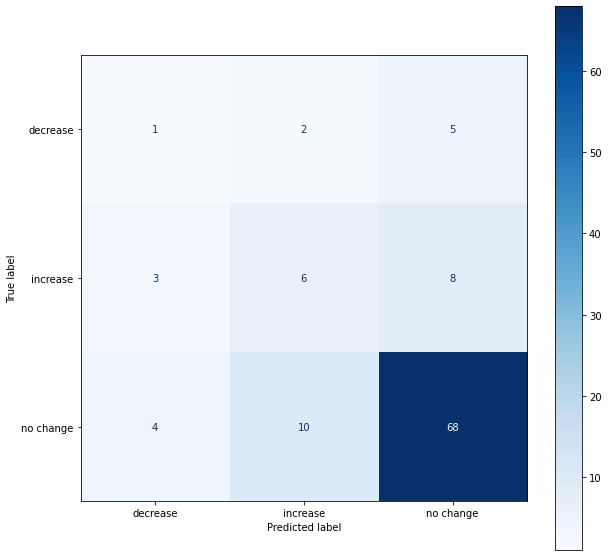

In [25]:
# confusion matrix
y_pred = clf.predict(X_test_bow)
cm = confusion_matrix(y_test, y_pred)
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

<br><br>


### Network Analysis

There are several options for creating a network graph. Nodes could include speaker, FOMC meeting, speech, audience or the city. For this initial network graph we started with FOMC meeting decision and the Fed Chair Speeches. This builds clusters of speeches around FOMC decisions. 

In [26]:
set(df_merge['speaker'])

{'Chair Janet L. Yellen',
 'Chairman Alan Greenspan',
 'Chairman Ben S. Bernanke',
 'Chairman Jerome H. Powell'}

In [27]:
df_merge.columns

Index(['event_date', 'fed_rate', 'action', 'rate_change', 'fed_chair', 'notes',
       'date_diff', 'start_date', 'end_date', 'event_id', 'link', 'title',
       'speaker', 'event', 'year', 'text', 'speech_date', 'text_len',
       'location', 'speech_id', 'filter_text', 'filter_text_len',
       'avg_word_length_filter'],
      dtype='object')

In [28]:
# filter dataset
#df = df_merge
#df = df_merge[df_merge['speaker'] == 'Chairman Jerome H. Powell']
df = df_merge[df_merge['speaker'] == 'Chairman Alan Greenspan']



# create the graph with the two node types
B = nx.Graph()
B.add_nodes_from(df['rate_change'], bipartite=0)
B.add_nodes_from(df['speech_id'], bipartite=1)

# add the weights
tuples = df[['rate_change','speech_id','rate_change']].to_numpy()
B.add_weighted_edges_from(tuples, weight='rate_change')

# test to see if the graph is connected
print('We confirm that connected status of the graph. Graph connected status:',nx.is_connected(B))

# verify that a bipartite graph was created
print('We also confirmed that the the graph is a bipartite graph. Graph bipartite status:',nx.is_bipartite(B))

# create node lists for each node type
rate_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
speech_nodes = set(B) - rate_nodes

We confirm that connected status of the graph. Graph connected status: False
We also confirmed that the the graph is a bipartite graph. Graph bipartite status: True


<Figure size 1080x720 with 0 Axes>

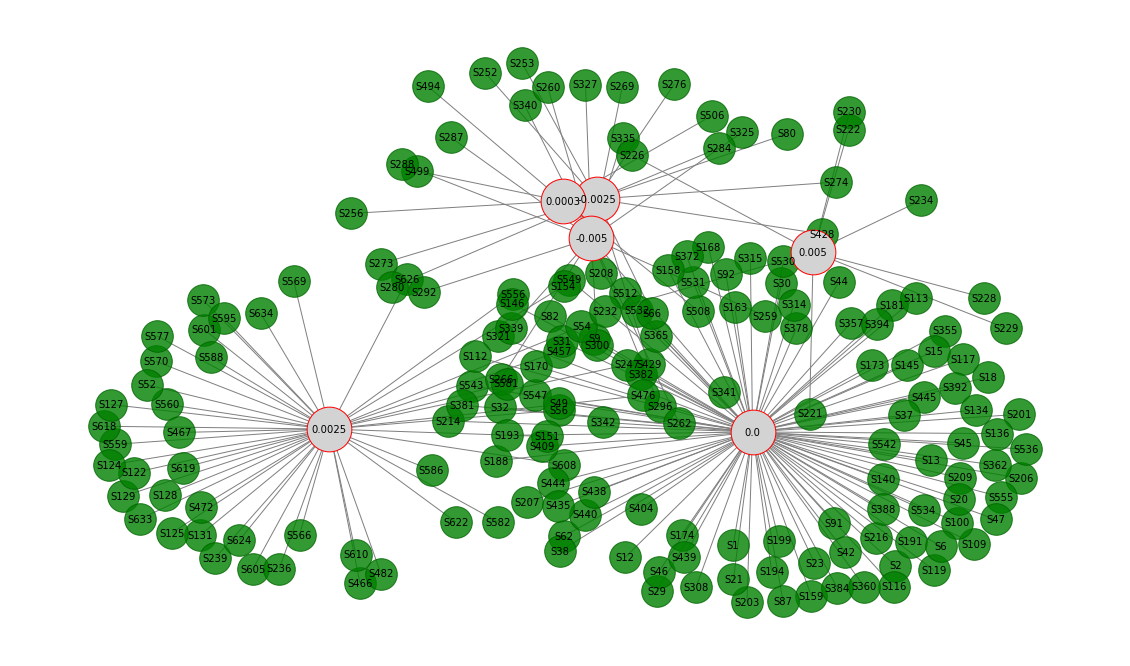

In [29]:
plt.figure(figsize = (15,10))
pos = nx.spring_layout(B, seed=34, k=0.35)
#pos = nx.random_layout(B)
#pos = nx.shell_layout(B)
#pos = nx.bipartite_layout(B,rate_nodes)

fig, ax = plt.subplots(figsize = (20,12))



#topic = weighted_2mode['Topic']
nx.draw_networkx_nodes(B,pos,
                       nodelist=speech_nodes,
                       node_color='green',
                       node_size=1000,
                       edgecolors='darkgreen',
                       alpha=0.8)

nx.draw_networkx_nodes(B,pos,
                       nodelist=rate_nodes,
                       node_color='lightgray',
                       node_size=2000,
                       edgecolors='red',
                       alpha=1)

nx.draw_networkx_edges(B, pos,
                       edge_color='gray',
                      )

ax.set_facecolor('white')
ax.axis('off')
fig.set_facecolor('white')
_0 = nx.draw_networkx_labels(B, pos, font_size=10)

This network graph does not convey much information about the relationship between the Fed Public Communications and the resuting decisoin by the FOMC meetings.

<br>

<br>

## Concerns

<br> 

### Extraordinary Actions By the Federal Reserve

Over the past few decades the Federal Reserve has engaged in extraordinary actions to protect the financial system and the economy against recession. 

The financial crisis of 2007 created a liquidity crisis that drove Federal Funds rate to effectively zero. Beginning in 2007, the federal funds target was reduced from 5.25% to a range of 0% to 0.25% in December 2008, which economists call the zero lower bound. By historical standards, rates were kept unusually low for an unusually long time to mitigate the effects of the 2007-2009 financial crisis and its aftermath. Starting in December 2015, the Fed began raising interest rates. With Funds rates at their lower bound the Fed initiated Quantitative Easing 1 (QE1, December 2008 to March 2010) - Federal Reserve announced that it would purchase up to $600 billion in agency mortgage-backed securities (MBS) and agency debt. 

To further bolster the economy the Fed engaged in Quantitative Easing 2 (QE2, November 2010 to June 2011) - On November 3, 2010, the Fed announced that it would purchase $600 billion of longer dated treasuries, at a rate of $75 billion per month. That program, popularly known as "QE2", concluded in June 2011.

QE2 was followed by QE3 in September 2012 to December 2013. This new round of quantitative easing provided for an open-ended commitment to purchase $40 billion agency mortgage-backed securities per month until the labor market improves "substantially".

Most recently in March 2020 with the looming economic impact of Corona virus and the associated recession concerns. The Federal Reserve again cut interest rates to close to the zero bound at 1 - 1.25%.

These anomaly in Monitory Policy add complexity to the analysis of FOMC decisions. At the zero lower bound for interest rates that messaging and communication to the general public may still indicate a desire for additional easing in monitory policy. If this easing takes place through asset purchases the result of the FOMC meeting will be no action however the messaging may indicate the continued desire to ease the monitory policy. 

<br>

### Tendency Towards No Action

The graph of FOMC decision highlights the imbalance in monitory policy. The vast majority of FOMC meeting end with the Federal Reserve deciding to take no action. Overall this is probably a good but would mean that a naive model the always predicts no action will perform fairly well.



<br><br>

## Final Thoughts

Based on the talking points from the Federal Reserve and the recent push towards open communication. I would expect that the prediction rates will increase for each successive Fed Chair. I would expect that speeches by Jerome Powell would be most predictive of all the periods.

<br>

## Project Plan and Team Roles


<br>

<b> Project Proposal </b>
* Build Template for Proposal - David
* Gather background docs - David
* Gather speech data - ?
* Gather FOMC Meeting Decision - ?
* Build Hypothesis - ?


<br>

<b> Final Project </b>
* Obtain 
    - Collect Speech Dataand - ?
    - FOMC Meeting Data - ?
* Scrub - Filter, Scrub and Tidy - ?
* Explore - Patterns from statistical model
* Model 
    * Networking Model 
    * Sentiment Analysis (Naive Bayes)
* iNterpret
    * 

<br><br>

## Other Links:
    
- https://www.youtube.com/watch?v=A9bQzmE6QGw

- https://www.youtube.com/watch?v=VzMiRsSOctI&t=1487s